<a href="https://colab.research.google.com/github/ccu412430024/Summer-Course/blob/main/Lab438_2024Summer_Course_HW_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 88 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Epoch 1/10
5/5 [==============================] - 9s 982ms/step - loss: 0.5736 - accuracy: 0.7386 - val_loss: 0.2666 - val_accuracy: 0.9500
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.2236 - accuracy: 0.9432 - val_loss: 0.1218 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 4s 807ms/step - loss: 0.1100 - accuracy: 0.9886 - val_loss: 0.0669 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 4s 829ms/step - loss: 0.0742 - accuracy: 0.9886 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 0.0512 - accuracy: 0.9886 - val_loss: 0.0322 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 4s 830ms/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 4s 679ms/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==========

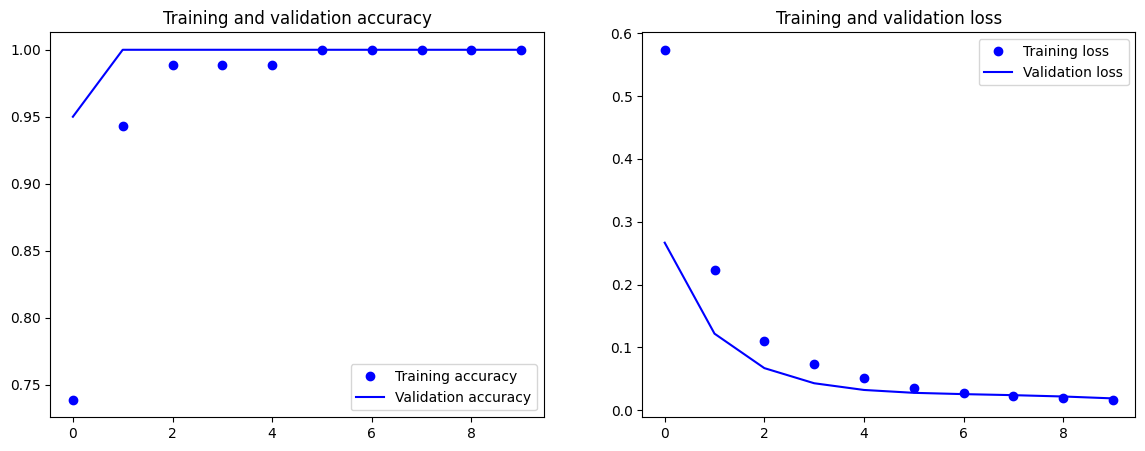

1/1 [==============================] - 2s 2s/step
Cat 0.983981192111969


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import Model, layers
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

# 資料目錄來源 以資料夾當作分類 , e.g. Datasets/cats, Datasets/dogs, ...
src_dir = r'Datasets/'
# 單次預測圖片
predict_img = r'Datasets/test1.png'

# 影像讀取處理
datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(src_dir, target_size=(224, 224), batch_size=20, subset='training')
valid_generator = datagen.flow_from_directory(src_dir, target_size=(224, 224), batch_size=20, subset='validation')

# 模型建立
mobilenetV2 = MobileNetV2(include_top=False, pooling='avg')
for mlayer in mobilenetV2.layers:
    mlayer.trainable = False
mobilenetV2output = mobilenetV2.layers[-1].output
fc = layers.Dense(units=train_generator.num_classes, activation='softmax', name='custom_fc')(mobilenetV2output)
classification_model = Model(inputs=mobilenetV2.inputs, outputs=fc)
classification_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# 訓練時間記錄回調函數
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

# 模型訓練
history = classification_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[time_callback])

# 訓練時間統計
times = time_callback.times
print(f"Training times per epoch: {times}")
print(f"Average training time per epoch: {np.mean(times)} seconds")

# 性能估計：繪製訓練和驗證的準確率和損失
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 單次預測
true_labels_dict = {}
for key in train_generator.class_indices:
    true_labels_dict[train_generator.class_indices[key]] = key

def pred(img_path):
    img = preprocess_input(np.array(Image.open(img_path).convert('RGB')))
    img = np.array([img])
    result_prob = classification_model.predict(img).tolist()[0]
    max_index = result_prob.index(max(result_prob))
    print(true_labels_dict[max_index], result_prob[max_index])

pred(predict_img)
